# Alias and IP-based clustering of lightning nodes
This notebook performs a clustering of multiple lightning nodes that are likely to belong to the same entity.
Every lightning node has a public key. In addition, they may broadcast an alias under which they are known, and an address specifying how to connect to them.

Two strategies are implemented:
1. Alias based clustering

 When multiple nodes have very similar aliases, it is likely that they are operated by the same entity. For example, a site named [lnbig.com](https://lnbig.com) appears to run multiple nodes with aliases like `LNBIG.com [lnd-01]`, `LNBIG.com [lnd-02]`, ...
 To identify _similar_ aliases, we employ a distance function comparing aliases in a pairwise fashion.
 Currently this distance function is `1/(length of longest common substring)`. To identify clusters, a threshold is defined.


2. IP-based clustering

 This one is very simple. If multiple nodes have been seen to be reachable at the same address, irrespective of the port, we assume these lightning nodes to be controlled by the same entity.

In [12]:
import pandas as pd
import numpy as np

from tqdm import tqdm # progress bars

from ipaddress import IPv4Address, IPv4Network, IPv6Address, IPv6Network

from jellyfish import * # edit distances
import pylcs # longest common subsequence

import scipy.cluster.hierarchy

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.axis as ax

pd.set_option('display.max_rows', 10000)
pd.set_option('max_colwidth', 10000)

# Data loading

In [13]:
data_dir = "../data/joined/level_2/"

In [14]:
# Load aliases
alias_file = data_dir+"node.csv"

node_aliases = pd.read_csv(alias_file)
# have each pub_key / alias combination in a separate row
node_aliases.alias = node_aliases.alias.apply(lambda x: x.split("|"))
node_aliases = node_aliases.explode("alias")
# filter to remove empty aliases
node_aliases = node_aliases[node_aliases.alias.str.len() > 0].copy()
print("Got",len(node_aliases),"aliases")

Got 7084 aliases


In [15]:
# Load IP addresses
ip_address_file = data_dir+"ip_address.csv"

node_ips = pd.read_csv(ip_address_file)
# have each pub_key / ip combination in a separate row
node_ips.ip_address = node_ips.ip_address.apply(lambda x: x.split("|"))
node_ips = node_ips.explode("ip_address")
# separate port and ip address for easier querying
node_ips['port'] = node_ips.ip_address.apply(lambda x: x.rsplit(":", 1)[1])
node_ips['ip_address'] = node_ips.ip_address.apply(lambda x: x.rsplit(":", 1)[0].strip("[]"))

# FILTER (remove addresses that don't make sense)
# https://en.wikipedia.org/wiki/Reserved_IP_addresses
def is_reserved_address(ip_address):
    if ".onion" in ip_address:
        return(False)
    special_use_nets_ipv4 = ["0.0.0.0/8", "10.0.0.0/8", "100.64.0.0/10", "127.0.0.0/8", "169.254.0.0/16", "172.16.0.0/12", "192.0.0.0/24", "192.0.2.0/24", "192.88.99.0/24", "192.168.0.0/16", "198.18.0.0/15", "198.51.100.0/24", "203.0.113.0/24", "224.0.0.0/4", "240.0.0.0/4", "255.255.255.255/32"]
    special_use_nets_ipv6 = ["::/0", "::/128", "::1/128", "::ffff:0:0/96", "::ffff:0:0:0/96", "64:ff9b::/96", "100::/64", "2001::/32", "2001:20::/28", "2001:db8::/32", "2002::/16", "fc00::/7", "fe80::/10", "ff00::/8"]
    if(":" in ip_address): #ipv6
        return(any([IPv6Address(ip_address) in IPv6Network(net) for net in special_use_nets_ipv6]))
    else: #ipv4
        return(any([IPv4Address(ip_address) in IPv4Network(net) for net in special_use_nets_ipv4]))
            
    
reserved_ips = node_ips.ip_address.apply(is_reserved_address)
print("Removing (pub_key counts):")
#print(node_ips[reserved_ips].groupby("ip_address").agg({"pub_key":"count"}))
print("Total: ", sum(reserved_ips))
node_ips = node_ips[~reserved_ips]

Removing (pub_key counts):
Total:  312


### On ASNs (autonomous system numbers) - Wikipedia
An autonomous system (AS) is a collection of connected Internet Protocol (IP) routing prefixes under the control of one or more network operators on behalf of a single administrative entity or domain that presents a common, clearly defined routing policy to the internet.

Originally the definition required control by a single entity, typically an Internet service provider (ISP) or a very large organization with independent connections to multiple networks, that adhered to a single and clearly defined routing policy, as originally defined in RFC 1771.[2] The newer definition in RFC 1930 came into use because multiple organizations can run Border Gateway Protocol (BGP) using private AS numbers to an ISP that connects all those organizations to the internet. Even though there may be multiple autonomous systems supported by the ISP, the internet only sees the routing policy of the ISP. That ISP must have an officially registered autonomous system number (ASN). 

In [16]:
whois_data = pd.read_csv(data_dir+"whois.csv")

In [17]:
from ast import literal_eval
whois_data = whois_data[~whois_data.entities.isna()]
whois_data["entities"] = whois_data["entities"].apply(literal_eval)
whois_data.explode("entities")[["asn", "query", "entities"]].groupby("entities").count()

,asn,query
entities,,
02421421011741,1,1
02558157000162,5,5
04368865000166,1,1
07625852000113,1,1
11966730000168,1,1
11INT,1,1
40432544083506,14,14
66925934000142,1,1
AA,2,2


In [18]:
# Retrieve whois information
# ONLY EXECUTE THIS IF YOU WANT TO RETRIEVE WHOIS INFORMATION YOURSELF!
if 'whois_data' not in vars():
    from ipwhois import IPWhois

    def lookup(ip_address):
        fail = {"query":ip_address}
        if ".onion" in ip_address:
            return(fail)
        else:
            try:
                res = IPWhois(ip_address).lookup_rdap(depth=1)
                return(res)
            except:
                print(ip_address, "couldn't be queried...")
                return(fail)
    whois_jsons = [ lookup(ip_address) for ip_address in tqdm(node_ips.ip_address.unique())]
    whois_data = pd.DataFrame.from_dict(whois_jsons)
    whois_data.to_csv(data_dir+"whois.csv", index=False)

In [19]:
# only keep asn and ip_address
whois_data = whois_data[["asn", "query"]].rename(columns={"query":"ip_address"})

# Defining distance based clustering functions

In [20]:
def compute_distances(alias_df, distance_func):
    # https://codereview.stackexchange.com/questions/37026/string-matching-and-clustering
    # generate pairwise indices of the alias dataframe without duplication
    pairwise_indices = np.triu_indices(len(alias_df.alias), 1)
    
    def get_dist(coord):
        i, j = coord
        # compute distance with some distance metric
        return distance_func(alias_df.alias.iloc[i], alias_df.alias.iloc[j])
    
    # compute pairwise distances
    dists = np.apply_along_axis(get_dist, 0, pairwise_indices)
    
    return(dists)

def cluster(alias_df, distance_measure, max_distance_threshold, dists=None):
    if dists is None:
        dists = compute_distances(alias_df, distance_measure)
    # perform hierarchical clustering based on distances
    Z = scipy.cluster.hierarchy.linkage(dists, method="complete")
    # return clusters based on a threshold t
    clusters = scipy.cluster.hierarchy.fcluster(Z, t=max_distance_threshold, criterion="distance")
    # assign cluster ids to original alias df
    alias_df["cluster"] = clusters
    
    return(alias_df, Z)


# distance measures
def relative_lcs(A, B):
    return(1 - pylcs.lcs2(A, B) / max(len(A), len(B)))

def lcs_distance(A, B):
    lcs = pylcs.lcs2(A, B)
    if(lcs == 0):
        return(1)
    else:
        return(1 / lcs)
    
def relative_levenshtein(A, B):
    levdist = levenshtein_distance(A, B)
    return(levdist/max(len(A), len(B)))

def relative_damerau_levenshtein(A, B):
    dalevdist = damerau_levenshtein_distance(A, B)
    return(dalevdist/max(len(A), len(B)))

def relative_hamming(A, B):
    hammdist = hamming_distance(A, B)
    return(hammdist/max(len(A), len(B)))

def jaro_distance(A, B):
    return(1 - jaro_similarity(A, B))

def jaro_winkler_distance(A, B):
    return(1 - jaro_winkler_similarity(A, B))

# Running alias clustering on subset ("LNBIG" + "Lightning" + random)

In [21]:
tmp_aliases = node_aliases[node_aliases.alias.str.contains("LNBIG")]
# add random "Lightning" aliases
tmp_aliases = tmp_aliases.append(node_aliases[node_aliases.alias.str.contains("Lightning")].sample(10, random_state=7))
# add entirely random aliases
tmp_aliases = tmp_aliases.append(node_aliases.sample(10, random_state=7)).drop_duplicates().reset_index(drop=True)
distance_measure = relative_lcs
max_distance_threshold = 1 - 0.7 # the common substring needs to account for 70% of all letters of the longer string

#distance_measure = lcs
#max_distance_threshold = 1/10 # common substring needs to be at least 10 letters

distance_measure = relative_lcs#jellyfish.levenshtein_distance
max_distance_threshold = 0.46

clusters, Z = cluster(tmp_aliases, distance_measure, max_distance_threshold)
#clusters

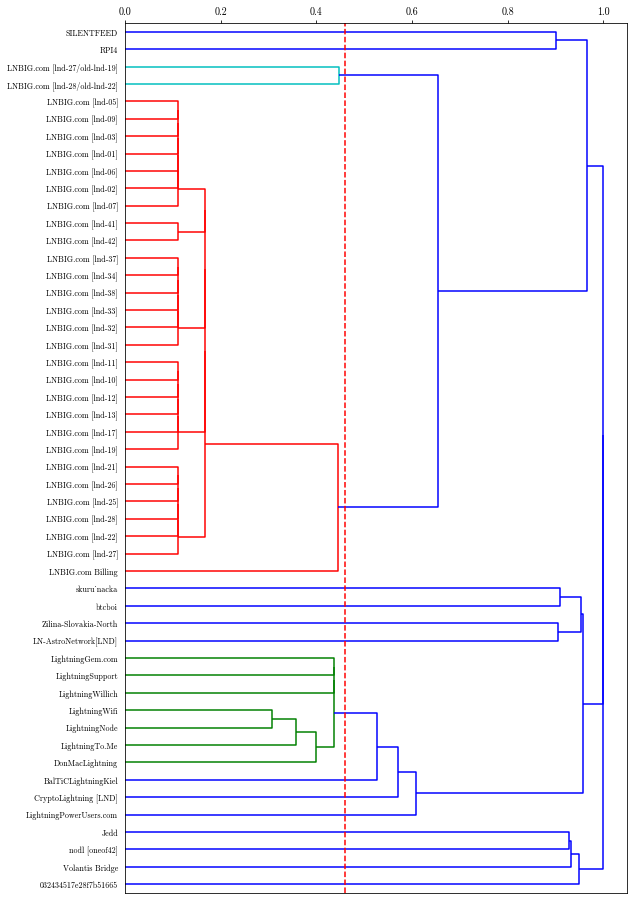

In [22]:
from matplotlib import rcParams
rcParams['font.family'] = 'cmr10'

# plot dendrogram (only makes sense for smaller data...)
fig = plt.figure(figsize=(9, 16))
ax = fig.add_subplot(1, 1, 1)
dn = scipy.cluster.hierarchy.dendrogram(Z, orientation="right", labels=clusters.alias.values, color_threshold=max_distance_threshold)
ax.axvline(x=max_distance_threshold, color='r', ls="--")
ax.xaxis.set_ticks_position("top")
plt.savefig("/tmp/plots.pdf", papertype="letter", bbox_inches="tight")

# Add a filter to only accept clusters with the same ASN

In [23]:
def get_same_asn_clusters(cluster_df):
    clusters_with_asn = cluster_df.merge(node_ips, how="left").merge(whois_data, how="left")
    clusters_with_asn = clusters_with_asn.dropna() # remove .onion and aliases without known IP
    same_asn_clusters = clusters_with_asn.groupby("cluster") \
      .filter(lambda x: (x["asn"].nunique() == 1) & (x["pub_key"].nunique() > 1)) \
      .sort_values("cluster")
    return(same_asn_clusters)

same_asn_clusters = get_same_asn_clusters(clusters)
same_asn_clusters.groupby(["cluster", "pub_key"])["alias"].agg(lambda x: '|'.join(set(x))).reset_index()

,cluster,pub_key,alias
0,13,02247d9db0dfafea745ef8c9e161eb322f73ac3f8858d8730b6fd97254747ce76b,LNBIG.com [lnd-26]
1,13,022755c3ff4e5a1d71f573cda4b315887fc00a9e5c9ea9a847d939f3e517e69a70,LNBIG.com [lnd-34]
2,13,022c260f9ad58196af280c80a96ec9eabf6404df59ff1a7553b0f381c875a29ba0,LNBIG.com [lnd-37]
3,13,024d2387409269f3b79e2708bb39b895c9f4b6a8322153af54eba487d4993bf60f,LNBIG.com [lnd-38]
4,13,0283ca0b7eca022bcf8f32aa418e5ff2bd375806faba40409cdc8e48c2b32ef725,LNBIG.com Billing
5,13,028a8e53d70bc0eb7b5660943582f10b7fd6c727a78ad819ba8d45d6a638432c49,LNBIG.com [lnd-33]
6,13,02bb24da3d0fb0793f4918c7599f973cc402f0912ec3fb530470f1fc08bdd6ecb5,LNBIG.com [lnd-10]
7,13,02c91d6aa51aa940608b497b6beebcb1aec05be3c47704b682b3889424679ca490,LNBIG.com [lnd-21]
8,13,02de11c748f5b25cfd2ce801176d3926bfde4de23b1ff43e692a5b76cf06805e4a,LNBIG.com [lnd-09]
9,13,0303a518845db99994783f606e6629e705cfaf072e5ce9a4d8bf9e249de4fbd019,LNBIG.com [lnd-25]


# Parameter evaluation
Evaluate distance measure parameters w.r.t.
- number of resulting clusters

Possible enhancement (would be todo):
- intra cluster alias diversity?

In [24]:
def evaluate_single_result(clustered_alias_df, Z=None):
    #clusters = get_same_asn_clusters(clustered_alias_df)
    clusters = get_same_asn_clusters(clustered_alias_df)[["pub_key", "cluster"]].drop_duplicates()
    
    node_count = len(clusters)
    cluster_count = len(clusters.groupby("cluster").filter(lambda x: len(x) > 1).groupby("cluster").count())
    cluster_count_min3 = len(clusters.groupby("cluster").filter(lambda x: len(x) > 2).groupby("cluster").count())
    cluster_count_min26 = len(clusters.groupby("cluster").filter(lambda x: len(x) >= 26).groupby("cluster").count())

    return(pd.Series({"node_count":node_count,
                      "cluster_count":cluster_count,
                      "cluster_count_min3":cluster_count_min3,
                      "cluster_count_min26":cluster_count_min26}))

def evaluate_measure(alias_df, dist_measure, thresholds):
    dists = compute_distances(alias_df, dist_measure)
    df = pd.DataFrame({"measure":dist_measure.__name__.replace("_"," "), "threshold": thresholds})
    stats = df.apply(lambda x:
                     evaluate_single_result(
                         *cluster(alias_df, dist_measure,
                                  x["threshold"], dists)),
                     axis=1)
    result = pd.concat([df, stats], axis=1)
    print("Finished", dist_measure.__name__)
    return(result)

In [173]:
evaluate_single_result(clusters)
tmp_aliases = node_aliases.copy()
results = pd.concat([
    evaluate_measure(tmp_aliases, relative_lcs, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, lcs_distance, 1/np.arange(1,15,1)),
    evaluate_measure(tmp_aliases, levenshtein_distance, np.arange(0, 10, 1)),
    evaluate_measure(tmp_aliases, relative_levenshtein, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, damerau_levenshtein_distance, np.arange(0, 10, 1)),
    evaluate_measure(tmp_aliases, relative_damerau_levenshtein, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, hamming_distance, np.arange(0, 10, 1)),
    evaluate_measure(tmp_aliases, relative_hamming, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, jaro_distance, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, jaro_winkler_distance, np.arange(0, 1, 0.01))
])


Finished relative_lcs
Finished lcs_distance
Finished levenshtein_distance
Finished relative_levenshtein
Finished damerau_levenshtein_distance
Finished relative_damerau_levenshtein
Finished hamming_distance
Finished relative_hamming
Finished jaro_distance
Finished jaro_winkler_distance


In [176]:
#results.to_csv("~/Desktop/results.csv", index=False)
results[results.cluster_count_min26 == 2].sort_values("node_count", ascending=False).dropna()

,measure,threshold,node_count,cluster_count,cluster_count_min3,cluster_count_min26
46,relative lcs,0.460000,314,115,10,2
49,relative lcs,0.490000,311,113,11,2
47,relative lcs,0.470000,310,113,10,2
48,relative lcs,0.480000,310,113,10,2
53,relative lcs,0.530000,309,111,13,2
54,relative lcs,0.540000,307,110,13,2
56,relative lcs,0.560000,307,110,13,2
50,relative lcs,0.500000,306,110,12,2
51,relative lcs,0.510000,306,110,12,2
52,relative lcs,0.520000,306,110,12,2


In [180]:
from plotnine import *
theme_publication = theme_bw() + theme(text=element_text(family="cmr10", size=12, color="black"),
                                       axis_title=element_text(size=14))


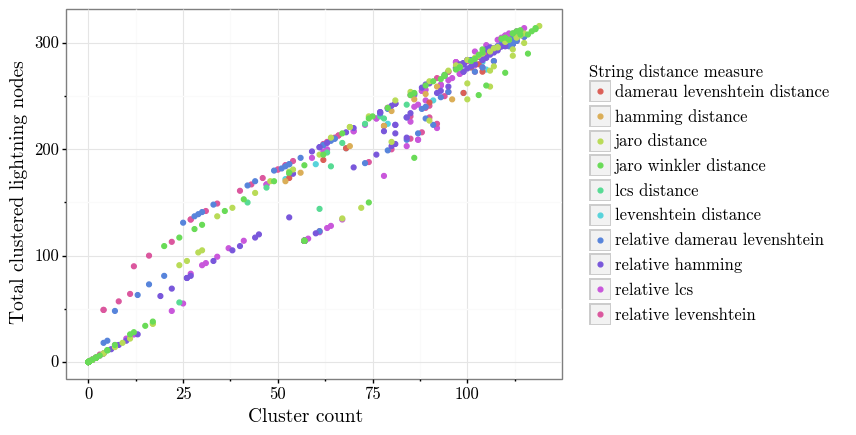

<ggplot: (8788881021879)>

In [181]:
plot = ggplot(results) +\
geom_point(aes(x="cluster_count", y="node_count", color="measure")) +\
labs(x="Cluster count", y="Total clustered lightning nodes", color="String distance measure") +\
theme_publication

plot

/opt/anaconda/3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/anaconda/3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/alias_clustering.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


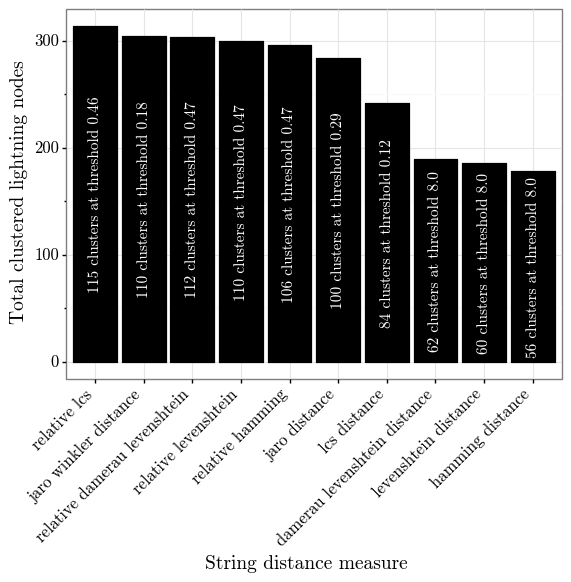

<ggplot: (8788881169114)>

In [199]:
bestMeasure_for_plot = results[results.groupby(['measure'])['cluster_count_min26'].transform(max) == results['cluster_count_min26']].reset_index(drop=True)
bestMeasure_for_plot = bestMeasure_for_plot.iloc[bestMeasure_for_plot.reset_index().groupby(["measure"])['node_count'].idxmax()]
#best

bestMeasure_for_plot = bestMeasure_for_plot.sort_values("node_count", ascending=False)
measure_list = bestMeasure_for_plot['measure'].values.tolist()
measure_cat = pd.Categorical(bestMeasure_for_plot['measure'], categories=measure_list)
bestMeasure_for_plot = bestMeasure_for_plot.assign(measure_cat = measure_cat)
bestMeasure_for_plot["label_pos"] = bestMeasure_for_plot["node_count"]/2
bestMeasure_for_plot["label_text"] = bestMeasure_for_plot.apply(
    lambda x: str(x["cluster_count"]) + " clusters at threshold "+str(round(x['threshold'], 2)), axis=1)

plot = ggplot(bestMeasure_for_plot) +\
geom_bar(aes(x="measure_cat", y="node_count"), stat="identity", colour="black", fill="black") +\
geom_text(aes(x="measure_cat", y="label_pos", label="label_text"), angle=90, colour="white") +\
labs(x="String distance measure", y="Total clustered lightning nodes") +\
theme_publication +\
theme(axis_text_x=element_text(rotation=45, vjust = 1, hjust=1))

plot.save("/tmp/alias_clustering.pdf", width=5, height=5)
plot


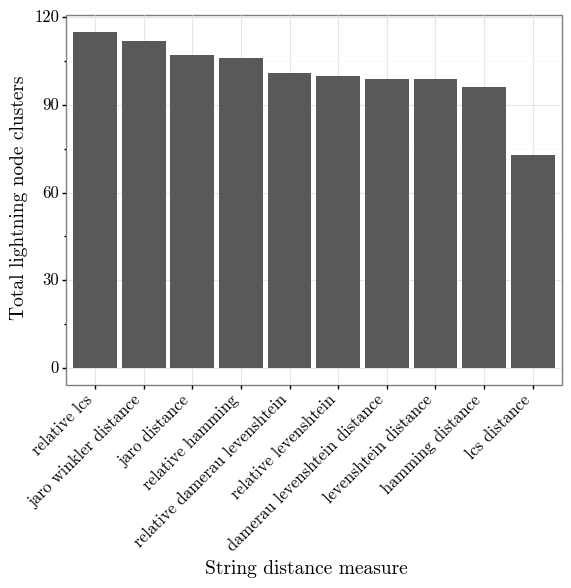

<ggplot: (8788878770166)>

In [136]:
plot = ggplot(bestMeasure_for_plot) +\
geom_bar(aes(x="measure_cat", y="cluster_count"), stat="identity") +\
labs(x="String distance measure", y="Total lightning node clusters") +\
theme_publication +\
theme(axis_text_x=element_text(rotation=45, vjust = 1, hjust=1))

plot

# Produce final alias / asn clustering with optimal parameter

In [186]:
best = results[results.groupby(['measure'])['cluster_count_min26'].transform(max) == results['cluster_count_min26']].reset_index(drop=True)
best = best[best["node_count"] == best["node_count"].max()].iloc[0]
best
#bestMeasure_for_plot

measure                relative lcs
threshold                      0.46
node_count                      314
cluster_count                   115
cluster_count_min3               10
cluster_count_min26               2
Name: 1, dtype: object

In [26]:
final_alias_cluster, _ = cluster(node_aliases, globals()[best.measure.replace(" ", "_")], best.threshold)
#final_alias_cluster, _ = cluster(node_aliases.head(1000), relative_lcs, 0.46)
alias_asn_clusters = get_same_asn_clusters(final_alias_cluster)[["pub_key", "cluster"]].drop_duplicates()
alias_asn_clusters["cluster_origin"] = "alias/asn"
alias_asn_clusters.head()

/opt/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pub_key,cluster,cluster_origin
1227,022c260f9ad58196af280c80a96ec9eabf6404df59ff1a7553b0f381c875a29ba0,189,alias/asn
1130,022755c3ff4e5a1d71f573cda4b315887fc00a9e5c9ea9a847d939f3e517e69a70,189,alias/asn
1072,02247d9db0dfafea745ef8c9e161eb322f73ac3f8858d8730b6fd97254747ce76b,189,alias/asn
1150,02287e816418be652d6b31f9e763b2494c534e2e8d314009527b596ea44896e846,191,alias/asn
564,020dcf8798bdc8316f6b84302e5895ab55832f73bd1d3775b1e96296ee4f42f069,191,alias/asn


# Clustering based on same IP / onion address

In [28]:
same_ip_nodes = node_ips.drop(columns=['port']) \
  .groupby('ip_address') \
  .filter(lambda x: x['pub_key'].nunique() > 1) \
  .sort_values('ip_address')
#cluster_addresses = pd.DataFrame({"ip_address":same_ip_nodes.ip_address.unique()})#.rename_axis("cluster").reset_index()
same_ip_nodes = same_ip_nodes.rename(columns={"ip_address":"cluster"})
same_ip_nodes["cluster_origin"] = "address"
same_ip_nodes.head()

,pub_key,cluster,cluster_origin
1491,02868e12f320073cad0c2959c42559fbcfd1aa326fcb943492ed7f02c9820aa399,104.198.96.115,address
1184,0268b84ff41b75477349c1b1a8ab77213294884f7816028bec6704b325718c89d0,104.198.96.115,address
3536,034653a43cb5857d6f75ff19866e27a8e03355827bf6036fd8d3c9478a37e33813,104.248.136.82,address
438,02251c2b931203848152b1c52e63ee91c74f53b0bfa8dd634a9b016d7b77c5afa9,104.248.136.82,address
1631,02939c016cd2cf08647a47815020c446e4f87252300c59cb35f14b7478465ab0aa,105.226.245.168,address


# Merge both clustering outputs

In [30]:
combined = pd.concat([alias_asn_clusters, same_ip_nodes])

548


In [194]:
G=nx.from_pandas_edgelist(combined, source="pub_key", target="cluster", create_using=nx.DiGraph)
l=list(nx.weakly_connected_components(G))
L=[dict.fromkeys(y,x) for x, y in enumerate(l)]
d={k: v for d in L for k, v in d.items()}
mapping = pd.DataFrame(list(d.items()), columns=['pub_key', 'newcluster'])
mapping = mapping.merge(combined, how="left", on="pub_key").drop(columns="cluster").dropna()
mapping = mapping.groupby(["newcluster", "pub_key"])["cluster_origin"].agg(lambda x: ' & '.join(set(x))).reset_index()
mapping = mapping.merge(node_aliases, how="left")

final_clusters = mapping.groupby(["newcluster", "pub_key", "cluster_origin"])["alias"].agg(lambda x: ' | '.join(set(x))).reset_index()
final_clusters = final_clusters.rename(columns={"newcluster":"cluster"})

In [203]:
#final_clusters.to_csv(data_dir + "alias_address_clusters.csv", index=False)
final_clusters

,cluster,pub_key,cluster_origin,alias
0,0,02130477ea5a2d5866281a8d4a00ba0b7c81606461a54737e609f5edb71fc3b011,alias/asn & address,sugartits
1,0,03482dc539383f17533dc53dd61c158668406b137565bedc18f0db9219df28361f,alias/asn & address,sugartits
2,1,024b5405c666fa3a555247030b0f6cb671d6cb67ebc93547857d33aca10657600a,alias/asn & address,jonbrosMontreal_LN1 | 024b5405c666fa3a5552
3,1,034df87aa03be1cdb60d8acfbe69d5cfde480c0d53f853f73d2243d3b2464857cb,alias/asn & address,jonbrosMontrealLN2
4,2,021d9deaf090a021c6e464e3becc5296161e8aaf5de3c7a1d517838cd74525834f,alias/asn & address,Gordon.Now
5,2,03b73bda986a22fbc47a2fc1764b59e779fb0473d0428dd4bca4ffb2a183eff2da,alias/asn & address,Gordon.Now Wallet
6,3,029ff7fc7d794d9569f3fd861cae0c8f9c529897bd7bcc24a555ccf0017d81a0eb,alias/asn & address,Bob-Lee
7,3,030b9aa75580563abe73199e0a2495d453e161fe7f2fe49153738f66057c74c5fc,alias/asn & address,Bob-ln
8,4,025614f51120a7d6d8ea78484880312a664e3f428150234ff0f6892151f5eff859,alias/asn & address,SatoshiLite
9,4,02d91a5dbb9202e724c3501338adb511c761e7851e004cba1bb413368aa54d394f,alias/asn & address,SatoshiLiteCasa


# Plot some information about the results

In [197]:
cluster_type_distribution = final_clusters.groupby("cluster_origin")["pub_key"].count()
cluster_type_distribution#.plot.bar(x='cluster_origin', y='pub_key', rot=0)

cluster_origin
address                281
alias/asn              123
alias/asn & address    185
Name: pub_key, dtype: int64

In [ ]:
cluster_size_distribution = final_clusters.groupby("cluster")["pub_key"].count().reset_index().groupby("pub_key").count()
cluster_size_distribution = cluster_size_distribution.reset_index().rename(columns={"pub_key":"pub_key count", "cluster":"cluster count"})
cluster_size_distribution.plot.bar(x='pub_key count', y='cluster count', rot=0)

# Open issues

- With the identified distance threshold, `LNBIG.com Billing` is not clustered with i.e. `LNBIG.com [lnd-07]`.
- The obvious cluster `Coinmageddon.com 001 (US)` ... `Coinmageddon.com 008 (Australia)` is not identified, due to different ASNs.
- If same ASN names like `lightning12`, `boblightning`, `robboblightn` would be a cluster
  - perhaps measure average distance between all pairs in a single cluster? Could this be the eval parameter?